# HPF: matching requested expectation and variance using SGD

The notebook demonstrates how priors matching requested values of prior predictive expectation and/or variance can be found for Hierarchical Poisson Matrix Factorization model using SGD.

## Setup 


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
#tfe = tf.contrib.eager

In [3]:
tf.__version__, tfp.__version__

('2.1.0', '0.9.0')

In [4]:
tf.executing_eagerly()

True

In [5]:
import time
import numpy as np
import pandas as pd

In [6]:
from aux import *

# Configuration

In [7]:
args = parse_script_args()

parsing: <-f>


In [8]:
np.random.seed(int(time.time()))
EID = np.random.randint(10000) # experiment id

In [9]:
SEED = args.get("SEED", 129)
np.random.seed(SEED)

In [10]:
K = args.get("K", 25) # factorization dimensions

In [11]:
NITER = args.get("NITER", 10000) + 1 # how many iterations
LR = args.get("LR", 0.1) # learning rate
LAMBDA = args.get("LAMBDA", 0.0) # regularization

In [12]:
# requested values
DESIRED_EXPECTATION = args.get("E", 25)
DESIRED_VARIANCE = args.get("V", 550)

# discrepancy measure: care about E=only expectation, V=only variance, EV=both
D = args.get("D", "EV")
if D=="E": DESIRED_VARIANCE = -1
if D=="V": DESIRED_EXPECTATION = -1
    
discrepancy_expectation = lambda expectation, variance: (expectation-DESIRED_EXPECTATION)**2 
discrepancy_variance    = lambda expectation, variance: (variance-DESIRED_VARIANCE)**2 
discrepancy_exp_var     = lambda expectation, variance: discrepancy_variance(expectation, variance) + \
                                                        discrepancy_expectation(expectation, variance)

NAME2DISCREPANCY = {"E":  discrepancy_expectation, "EV": discrepancy_exp_var, "V": discrepancy_variance}
discrepancy = NAME2DISCREPANCY[D]

In [13]:
# sampling strategy: independent or the same samples for E & V
SAMPLING = args.get("SAMPLING", 0)
if SAMPLING==0 and LAMBDA<=0.0:
    if D=="E": SAMPLING = 2 # if V is not used
    if D=="V": SAMPLING = 3 # if E is not used

NSAMPLES_LATENT = args.get("S", 1000) # how many samples of latent variables
NSAMPLES_OUTPUT = args.get("SY", 10)  # how many samples of outputs for each latent

LOG_SCORE_DERIVATIVES = True

In [14]:
# optimization initial values 

a0, ap0, bp0 = args.get("a", 3.0), args.get("ap", 3.0), args.get("bp", 1.0)
c0, cp0, dp0 = args.get("c", 3.0), args.get("cp", 3.0), args.get("dp", 1.0)


# which parameter space
PARAMETRIZATION = args.get("TRANSFORMATION", "abcd") # musigma/abcd
# how to transform from unbounded space to a bounded one and vice versa
VARIABLES_TRANSFORMATION = args.get("TRANSFORMATION", "softplus") # softplus/exp/pow10
# which of the parameters to train
TRAINABLE = args.get("TRAIN", "012345") 

In [15]:
DESCRIPTION = dict2str(globals()).replace("NSAMPLES", "S").replace("DESIRED_", "").replace("EXPECTATION", "E").replace("VARIANCE", "V").replace("TRAINABLE", "TT")
DESCRIPTION = "a=%s ap=%s bp=%s c=%s cp=%s dp=%s %s" % (a0, ap0, bp0, c0, cp0, dp0,DESCRIPTION)
print("DESCRIPTION: %s" % DESCRIPTION)

ID = str(args.get("ID", DESCRIPTION))

DESCRIPTION: a=3.0 ap=3.0 bp=1.0 c=3.0 cp=3.0 dp=1.0 D=EV E=25 V=550 EID=8335 K=25 LAMBDA=0.0 LR=0.1 NITER=10001 S_LATENT=1000 S_OUTPUT=10 PARAMETRIZATION=abcd SAMPLING=0 SEED=129 TT=012345 VARIABLES_TRANSFORMATION=softplus


# Parameters transformation

For HPF, we consider only one parametrization (the one from the original paper),
so the parametrization is an identity.
However, we still need to perform a transformation from unconstrained space.

In [16]:
def abcdef2abcdef(a, b, c, d, e, f, env=tf):    
    return a, b, c, d, e, f

In [17]:
#from tensorflow.contrib.distributions import softplus_inverse
#softplus_inverse = lambda v: tf.log(tf.exp(v)-1.0)
softplus_inverse = tfp.math.softplus_inverse
NAME2TRANSFORMATION = {"softplus": (tf.nn.softplus, softplus_inverse), 
                       "exp": (tf.exp, tf.math.log),
                       "pow10": (lambda v: tf.math.pow(10.0, v), lambda v: tf.math.log(v)*0.434294482)}
forward_transformation, backward_transformation = NAME2TRANSFORMATION[VARIABLES_TRANSFORMATION]

print("forward_transformation:=%s backward_transformation:=%s" % 
      (forward_transformation.__name__, backward_transformation.__name__))
#print("  transformation prec:", np.array(backward_transformation(forward_transformation(a0))-a0))

NAME2PARAMETRIZATION = {"abcd": (abcdef2abcdef, abcdef2abcdef)}
forward_parametrization, backward_parametrization = NAME2PARAMETRIZATION[PARAMETRIZATION]

print("forward_parametrization:=%s backward_parametrization:=%s " % 
      (forward_parametrization.__name__, backward_parametrization.__name__))
#print("  parametrization prec:", forward_parametrization(*backward_parametrization(a0,b0,c0,d0))-np.array([a0,b0,c0,d0]))
#assert (np.round(inverse_parametrization(*parametrization(a0,b0,c0,d0))-np.array([a0,b0,c0,d0]),2) ==0).all()

forward_transformation:=softplus backward_transformation:=softplus_inverse
forward_parametrization:=abcdef2abcdef backward_parametrization:=abcdef2abcdef 


# Expectation & variance estimators

In [18]:
from hpf_model import create_moments_estimator, empirical_Ey_and_Ey2_tf, empirical_Ey_and_Ey2_tf_logscore
theoretical_moments = create_moments_estimator(K=K, ESTIMATOR_NO=-1)
empirical_moments   = create_moments_estimator(K=K, ESTIMATOR_NO=SAMPLING, 
    empirical_Ey_and_Ey2=empirical_Ey_and_Ey2_tf_logscore if LOG_SCORE_DERIVATIVES else empirical_Ey_and_Ey2_tf)
print("empirical_moments := %s" % empirical_moments.__name__)

empirical_moments := empirical_moments_fully_decoupled


In [19]:
e, v = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
print("Initialization: a=%.3f\tap=%.3f\tbp=%.3f\ta=%.3f\tap=%.3f\tbp=%.3f\t=> E=%.4f \tV=%.4f" % 
      (a0, ap0, bp0, c0, cp0, dp0, e, v))

Initialization: a=3.000	ap=3.000	bp=1.000	a=3.000	ap=3.000	bp=1.000	=> E=505.8573 	V=722606.8320


# Find hyperparameters matching desired values

In [20]:
#tf.random.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [21]:
# init (unbounded) params
float2 = lambda v: tf.Variable(v, dtype=tf.float64)

a0tf, ap0tf, bp0tf, c0tf, cp0tf, dp0tf = float2(a0), float2(ap0), float2(bp0), float2(c0), float2(cp0), float2(dp0)
i0, i1, i2, i3, i4, i5 = backward_parametrization(a0tf, ap0tf, bp0tf, c0tf, cp0tf, dp0tf, env=tf)

p0u = tf.Variable(backward_transformation(i0), name="0", dtype=tf.float64) 
p1u = tf.Variable(backward_transformation(i1), name="1", dtype=tf.float64) 
p2u = tf.Variable(backward_transformation(i2), name="2", dtype=tf.float64) 
p3u = tf.Variable(backward_transformation(i3), name="3", dtype=tf.float64) 
p4u = tf.Variable(backward_transformation(i4), name="4", dtype=tf.float64) 
p5u = tf.Variable(backward_transformation(i5), name="5", dtype=tf.float64) 

In [22]:
trainable_variables = [var for var in [p0u, p1u, p2u, p3u, p4u, p5u] if var.name.split(":")[0] in TRAINABLE]
#optimizer = tf.train.AdamOptimizer(learning_rate=LR)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
start = time.time()
computation_time = 0.0
results = []

In [23]:
best_loss = float("inf")
best_hyperparameters = -1.0, -1.0, -1.0, -1.0, -1.0, -1.0
best_E, best_V = -1.0, -1.0

In [24]:
for iteration in range(NITER):
  
    ##########################################################################################################
    # Optimization
    iteration_start_time = time.time()
        
    with tf.GradientTape() as tape:        
        p0,p1,p2 = forward_transformation(p0u), forward_transformation(p1u), forward_transformation(p2u)  
        p3,p4,p5 = forward_transformation(p3u), forward_transformation(p4u), forward_transformation(p5u)  
        
        a, ap, bp, c, cp, dp =  forward_parametrization(p0,p1,p2,p3,p4,p5)           
        expectation, variance = empirical_moments(a, ap, bp, c, cp, dp, NSAMPLES_LATENT, NSAMPLES_OUTPUT)        
        loss = discrepancy(expectation, variance) -(LAMBDA*variance if LAMBDA>0 else 0.0) # just to be sure
    
    grads = tape.gradient(loss, trainable_variables)              
    optimizer.apply_gradients(zip(grads, trainable_variables))#, global_step=tf.train.get_or_create_global_step())
    computation_time += (time.time()-iteration_start_time)
    
    if loss<best_loss: #TODO Can do better by evaluating here the loss with more samples
        #print("%i/%i: best: old=%.2f new=%.2f" % (iteration, NITER, best_loss, loss.numpy()))
        best_loss = loss.numpy()
        best_hyperparameters = a.numpy(), ap.numpy(), bp.numpy(), c.numpy(), cp.numpy(), dp.numpy()
        
    ##########################################################################################################
    # Reporting:
    failed = not is_valid(np.array(expectation))
    elapsed = time.time() - start
    if (failed) or (iteration%10==0 and iteration<100) or (iteration%100==0): 
        eval_start = time.time()
        best_E, best_V = theoretical_moments(*best_hyperparameters)
        expectation_exact, variance_exact = theoretical_moments(a, ap, bp, c, cp, dp)        
        
        r = (ID, D, SEED,
             a0, ap0, bp0, c0, cp0, dp0, NITER, LR,
             K, NSAMPLES_LATENT, NSAMPLES_OUTPUT, 
             DESIRED_EXPECTATION, DESIRED_VARIANCE, LAMBDA,
             ((NITER-1) if failed else iteration), computation_time, 
             a.numpy(), ap.numpy(), bp.numpy(), c.numpy(), cp.numpy(), dp.numpy(),
             loss.numpy(), expectation_exact, variance_exact, expectation.numpy(), variance.numpy(),
             best_loss, *best_hyperparameters, best_E, best_V,
             failed)
        results.append(r)

    #if (failed) or (iteration<10) or (iteration<1000 and iteration%100==0)  or (iteration%1000==0):         
        print("[%.2f][%.2f] best:\tloss:%.1f\thyperparams: a=%.3f ap=%.3f bp=%.3f a=%.3f ap=%.3f bp=%.3f => E=%.3f V=%.3f" % 
              (computation_time, elapsed, best_loss, *best_hyperparameters, best_E, best_V))        
        print("[%.2f][%.2f] %i/%i,\tloss:%.1f\thyperparams: a=%.3f ap=%.3f bp=%.3f a=%.3f ap=%.3f bp=%.3f" % 
              (computation_time, elapsed, iteration, NITER, loss.numpy(), 
               a.numpy(), ap.numpy(), bp.numpy(), c.numpy(), cp.numpy(), dp.numpy()))                
        print(" empirical: E: %.2f V: %.2f" % (expectation, variance) )    
        print(" theoretic: E: %.2f V: %.2f" % (expectation_exact, variance_exact) )
        print(" desired: E: %.2f V: %.2f (eval time=%.2f)" % (DESIRED_EXPECTATION, DESIRED_VARIANCE, time.time()-eval_start) )                
        sys.stdout.flush()

    if failed:
        print("Error: ran into invalid values!")
        break

[0.90][0.93] best:	loss:113381537081.6	hyperparams: a=3.000 ap=3.000 bp=1.000 a=3.000 ap=3.000 bp=1.000 => E=505.857 V=722606.832
[0.90][0.93] 0/10001,	loss:113381537081.6	hyperparams: a=3.000 ap=3.000 bp=1.000 a=3.000 ap=3.000 bp=1.000
 empirical: E: 518.52 V: 337271.39
 theoretic: E: 506.11 V: 821952.10
 desired: E: 25.00 V: 550.00 (eval time=7.87)
[1.45][9.36] best:	loss:113381537081.6	hyperparams: a=3.000 ap=3.000 bp=1.000 a=3.000 ap=3.000 bp=1.000 => E=507.246 V=742773.403
[1.45][9.36] 10/10001,	loss:233385754675.7	hyperparams: a=2.893 ap=2.794 bp=1.066 a=2.911 ap=3.039 bp=1.066
 empirical: E: 418.69 V: 483649.99
 theoretic: E: 431.60 V: 658578.67
 desired: E: 25.00 V: 550.00 (eval time=7.79)
[2.00][17.70] best:	loss:16216780756.9	hyperparams: a=2.785 ap=2.885 bp=1.141 a=2.804 ap=3.132 bp=1.141 => E=336.324 V=316044.321
[2.00][17.70] 20/10001,	loss:18098391680.8	hyperparams: a=2.687 ap=2.968 bp=1.212 a=2.707 ap=3.218 bp=1.212
 empirical: E: 265.05 V: 135080.05
 theoretic: E: 270.5

[76.75][268.61] best:	loss:874933585.4	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.094 V=130098.315
[76.75][268.61] 1500/10001,	loss:8272970126.3	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290
 empirical: E: 211.46 V: 91505.68
 theoretic: E: 223.13 V: 120785.69
 desired: E: 25.00 V: 550.00 (eval time=8.04)
[81.15][281.07] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.739 V=136505.122
[81.15][281.07] 1600/10001,	loss:9875010884.9	hyperparams: a=2.653 ap=2.869 bp=1.290 a=2.669 ap=3.742 bp=1.290
 empirical: E: 229.96 V: 99922.88
 theoretic: E: 223.21 V: 128978.99
 desired: E: 25.00 V: 550.00 (eval time=7.74)
[85.64][293.31] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.176 V=175170.679
[85.64][293.31] 1700/10001,	loss:9963364125.1	hyperparams: a=2.668 ap=2.855 bp=1.283 a=2.683 ap=3.737 bp=1.283
 empirical: E: 244.99 V: 100366.41
 theoretic: 

[190.35][567.70] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.223 V=132577.130
[190.35][567.70] 3800/10001,	loss:6955182661.5	hyperparams: a=2.612 ap=2.901 bp=1.309 a=2.629 ap=3.759 bp=1.309
 empirical: E: 202.44 V: 83947.55
 theoretic: E: 208.06 V: 102616.15
 desired: E: 25.00 V: 550.00 (eval time=8.29)
[195.44][581.09] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.083 V=115976.933
[195.44][581.09] 3900/10001,	loss:4012614428.9	hyperparams: a=2.612 ap=2.901 bp=1.309 a=2.629 ap=3.758 bp=1.309
 empirical: E: 190.83 V: 63894.98
 theoretic: E: 208.15 V: 104750.53
 desired: E: 25.00 V: 550.00 (eval time=8.76)
[200.61][595.03] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.130 V=116239.083
[200.61][595.03] 4000/10001,	loss:2113313902.3	hyperparams: a=2.607 ap=2.905 bp=1.312 a=2.625 ap=3.760 bp=1.312
 empirical: E: 193.84 V: 46520.48
 theore

[302.96][867.71] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.422 V=122264.031
[302.96][867.71] 6100/10001,	loss:7029912373.1	hyperparams: a=2.614 ap=2.899 bp=1.308 a=2.633 ap=3.757 bp=1.308
 empirical: E: 197.51 V: 84394.40
 theoretic: E: 208.92 V: 100502.78
 desired: E: 25.00 V: 550.00 (eval time=7.71)
[307.53][880.00] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=223.214 V=130104.265
[307.53][880.00] 6200/10001,	loss:902711466554.8	hyperparams: a=3.142 ap=2.557 bp=1.060 a=3.172 ap=3.331 bp=1.060
 empirical: E: 566.89 V: 950661.14
 theoretic: E: 520.13 V: 1002128.06
 desired: E: 25.00 V: 550.00 (eval time=7.55)
[312.00][892.04] best:	loss:434382318.8	hyperparams: a=2.653 ap=2.868 bp=1.290 a=2.670 ap=3.742 bp=1.290 => E=222.880 V=115816.367
[312.00][892.04] 6300/10001,	loss:1068132028677.2	hyperparams: a=3.117 ap=2.539 bp=1.084 a=3.147 ap=3.417 bp=1.084
 empirical: E: 453.65 V: 1034054.6

[414.87][1165.29] best:	loss:46.4	hyperparams: a=1.646 ap=3.460 bp=2.479 a=1.591 ap=5.640 bp=2.479 => E=18.232 V=449.499
[414.87][1165.29] 8400/10001,	loss:25434.2	hyperparams: a=1.623 ap=3.476 bp=2.505 a=1.567 ap=5.675 bp=2.505
 empirical: E: 17.33 V: 390.70
 theoretic: E: 17.26 V: 415.77
 desired: E: 25.00 V: 550.00 (eval time=7.80)
[419.35][1177.59] best:	loss:46.4	hyperparams: a=1.646 ap=3.460 bp=2.479 a=1.591 ap=5.640 bp=2.479 => E=18.207 V=453.221
[419.35][1177.59] 8500/10001,	loss:47632.3	hyperparams: a=1.623 ap=3.476 bp=2.505 a=1.567 ap=5.675 bp=2.505
 empirical: E: 17.03 V: 331.90
 theoretic: E: 17.22 V: 388.35
 desired: E: 25.00 V: 550.00 (eval time=7.78)
[423.96][1189.98] best:	loss:46.4	hyperparams: a=1.646 ap=3.460 bp=2.479 a=1.591 ap=5.640 bp=2.479 => E=18.186 V=436.109
[423.96][1189.98] 8600/10001,	loss:48512.7	hyperparams: a=1.623 ap=3.476 bp=2.505 a=1.567 ap=5.675 bp=2.505
 empirical: E: 17.26 V: 329.88
 theoretic: E: 17.28 V: 392.07
 desired: E: 25.00 V: 550.00 (eval 

In [25]:
path = ID+".csv"
print("Saving results to: %s" % path)
df = pd.DataFrame(results)
CN = ["ID", "D", "SEED", "a0", "ap0", "bp0", "c0", "cp0", "dp0", "NITER", "LR", "K", "S", "SY", "E", "V", "LAMBDA",
      "iteration", "elapsed", "a", "ap", "bp", "c", "cp", "dp", "loss", "Et", "Vt", "Ee", "Ve", 
      "best_loss", "best_a", "best_ap", "best_bp", "best_c", "best_cp", "best_dp", "best_E", "best_V", "failed"]
df.rename(columns=dict(enumerate(CN)), inplace=True)
df.to_csv(path, header=True, index=False);

Saving results to: a=3.0 ap=3.0 bp=1.0 c=3.0 cp=3.0 dp=1.0 D=EV E=25 V=550 EID=8335 K=25 LAMBDA=0.0 LR=0.1 NITER=10001 S_LATENT=1000 S_OUTPUT=10 PARAMETRIZATION=abcd SAMPLING=0 SEED=129 TT=012345 VARIABLES_TRANSFORMATION=softplus.csv


# Visualization

In [26]:
from aux_plt import *
import warnings
warnings.filterwarnings("ignore")

## Convergence analysis

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


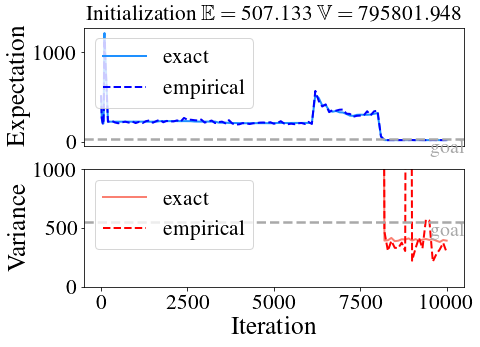

In [27]:
  start_plotting(cmbright=False)
  ax2 = plt.subplot(212)
  ax1 = plt.subplot(211)

  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  iteration = means.iteration
    
  e, var = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
  plt.title(r"Initialization $\mathbb{E}=%.3f$ $\mathbb{V}=%.3f$" % (e, var))
    
  plt.sca(ax1)
  errorfill((iteration), (means["Et"]), (stds["Et"]), color="dodgerblue", 
            alpha_fill=0.1, label="exact", smooth=0)
  errorfill((iteration), (means["Ee"]), (stds["Ee"]), color="blue", 
            alpha_fill=0.1, label="empirical", smooth=0, ls="--")
  plt.sca(ax2)
  errorfill((iteration), (means["Vt"]), (stds["Vt"]), color="salmon", 
            alpha_fill=0.1, label="exact", smooth=0)
  errorfill((iteration), (means["Ve"]), (stds["Ve"]), color="red", 
            alpha_fill=0.1, label="empirical", smooth=0, ls="--")

  plt.sca(ax2)
  plt.xlabel("Iteration")
  plt.ylabel(r"Variance")
  goal = means["V"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
  plt.legend()
  plt.ylim(0,1000)
  
  plt.sca(ax1)
  plt.legend()
  plt.xticks([],[])
  plt.ylabel(r"Expectation")
  goal = means["E"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
    
  plt.show()

## The best value(s) found up to certain iteration

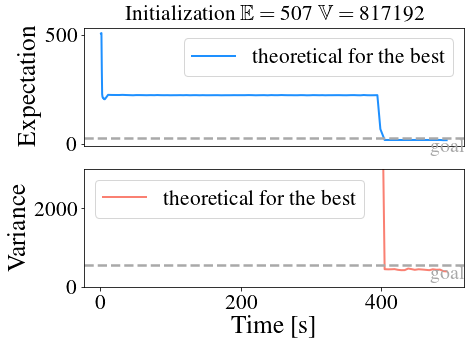

In [28]:
  start_plotting(cmbright=False)
  ax2 = plt.subplot(212)
  ax1 = plt.subplot(211)

  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  #xs = means.iteration; xlabel = "Iteration" # Iteration on horizontal axis
  xs = means.elapsed; xlabel = "Time [s]" # Time on horizontal axis
    
  e, var = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
  plt.title(r"Initialization $\mathbb{E}=%.0f$ $\mathbb{V}=%.0f$" % (e, var))
    
  plt.sca(ax1)
  errorfill((xs), (means["best_E"]), (stds["best_E"]), color="dodgerblue", 
            alpha_fill=0.1, label="theoretical for the best", smooth=0)
  plt.sca(ax2)
  errorfill((xs), (means["best_V"]), (stds["best_V"]), color="salmon", 
            alpha_fill=0.1, label="theoretical for the best", smooth=0)

  plt.sca(ax2)      
  plt.xlabel(xlabel)
  plt.ylabel(r"Variance")
  goal = means["V"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
  plt.legend()
  plt.ylim(0,3000)
    
  
  plt.sca(ax1)
  plt.legend()
  plt.xticks([],[])
  plt.ylabel(r"Expectation")
  goal = means["E"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
    
  plt.show()

## Hyperameters' values during optimization

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


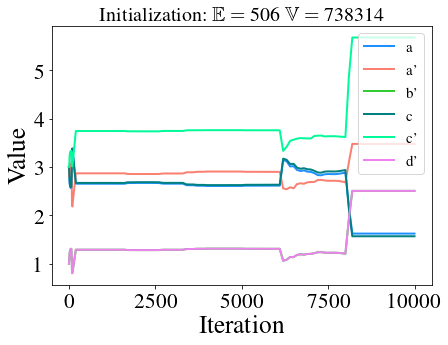

In [29]:
  start_plotting(cmbright=False)
  
  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  iteration = means.iteration  
  
  e, var = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
  plt.title(r"Initialization: $\mathbb{E}=%.0f$ $\mathbb{V}=%.0f$" % (e, var), fontsize=20)
  
  errorfill((iteration), (means["a"]), (stds["a"]), color=COLORS[0], alpha_fill=0.2, smooth=0, ls="-", label="a")
  errorfill((iteration), (means["ap"]), (stds["ap"]), color=COLORS[1], alpha_fill=0.2, smooth=0, ls="-", label="a'")
  errorfill((iteration), (means["bp"]), (stds["bp"]), color=COLORS[2], alpha_fill=0.2, smooth=0, ls="-", label="b'")
  errorfill((iteration), (means["c"]), (stds["c"]), color=COLORS[3], alpha_fill=0.2, smooth=0, ls="-", label="c")
  errorfill((iteration), (means["cp"]), (stds["cp"]), color=COLORS[4], alpha_fill=0.2, smooth=0, ls="-", label="c'")
  errorfill((iteration), (means["dp"]), (stds["dp"]), color=COLORS[5], alpha_fill=0.2, smooth=0, ls="-", label="d'")

  plt.legend(fontsize=15)  
  plt.xlabel("Iteration")
  plt.ylabel("Value")
  plt.show()  